# Step 1: Create fire smoke estimates

**Prodject Description**: \
The goal of this project is to analyze the impact of wildfires on air quality in the city of Springfield.
The analysis involves processing wildfire data to determine the impact of smoke from wildfires on the city's air quality.
The analysis includes the following steps:
1. Processing wildfire data to identify relevant fire records. This includes filtering out non-wildfire incidents and applying date and location filters.
2. Calculating the impact of each fire based on its size, distance from the city, and other factors.
3. Analyzing the cumulative impact of wildfires on air quality over multiple years.
4. Visualizing the results to identify trends and patterns in the data.
5. Validating the smoke impact data against actual air quality data from the EPA.
6. Forecasting future smoke impact scores based on historical data. 

In [1]:
%%capture
%pip install geojson
%pip install pyproj

In [2]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import geojson
from datetime import datetime
from pathlib import Path
from pyproj import Transformer, Geod
import matplotlib.pyplot as plt
import re

In [3]:
# Configuration settings
ANALYSIS_CONFIG = {
    'METERS_TO_MILES': 0.00062137,
    'MAX_DISTANCE': 650,  # miles
    'FIRE_SEASON': (5, 10),  # May to October
    'DATE_PATTERN': r"Listed Wildfire Discovery Date\(s\): ([^|]+)"
}

# Initialize spatial calculation tools
coord_transformer = Transformer.from_crs("ESRI:102008", "EPSG:4326")
distance_calculator = Geod(ellps='WGS84')

In [4]:
# Utility functions for data processing
def parse_discovery_date(date_info):
    """Extract earliest fire discovery date from complex date string"""
    try:
        if not date_info:
            return None
            
        date_section = re.search(ANALYSIS_CONFIG['DATE_PATTERN'], date_info)
        if not date_section:
            return None
            
        # Find all dates in YYYY-MM-DD format
        dates = re.findall(r'(\d{4}-\d{2}-\d{2})', date_section.group(1))
        if not dates:
            return None
            
        # Convert and find earliest date
        earliest = min(datetime.strptime(d, '%Y-%m-%d') for d in dates)
        return earliest.strftime('%m/%d/%Y')
        
    except Exception as e:
        print(f"Date parsing error: {e}")
        return None
    

def check_fire_season(date_str):
    """Determine if date falls within fire season (May-October)"""
    if not date_str:
        return True
        
    try:
        date = datetime.strptime(date_str, '%m/%d/%Y')
        season_start, season_end = ANALYSIS_CONFIG['FIRE_SEASON']
        return season_start <= date.month <= season_end
    except:
        print(f"Season check error for date: {date_str}")
        return True

def transform_perimeter_coords(coord_list):
    """Convert coordinates between coordinate systems"""
    transformed = []
    for coord in coord_list:
        if len(coord) >= 2:
            try:
                lat, lon = coord_transformer.transform(coord[0], coord[1])
                transformed.append((lat, lon))
            except Exception as e:
                print(f"Coordinate transformation error: {e}")
    return transformed

def calculate_distance_to_city(perimeter_coords, city_location):
    """Calculate minimum distance from fire perimeter to city"""
    try:
        if not perimeter_coords:
            return None
            
        city_lon, city_lat = city_location[1], city_location[0]
        distances = []
        
        for coord in perimeter_coords:
            result = distance_calculator.inv(city_lon, city_lat, coord[1], coord[0])
            miles = result[2] * ANALYSIS_CONFIG['METERS_TO_MILES']
            distances.append(miles)
            
        return min(distances) if distances else None
        
    except Exception as e:
        print(f"Distance calculation error: {e}")
        return None

def calculate_smoke_impact(fire_size, distance):
    """Calculate relative impact score based on fire size and distance"""
    try:
        if distance is None or distance <= 0 or fire_size <= 0:
            return 0
            
        size_factor = np.log1p(fire_size)
        return size_factor / (distance ** 2)
        
    except Exception as e:
        print(f"Impact calculation error: {e}")
        return 0

def validate_fire_data(fire_feature):
    """Check if fire data contains all required information"""
    try:
        if not isinstance(fire_feature, dict):
            return False
            
        if not all(key in fire_feature for key in ['attributes', 'geometry']):
            return False
            
        required_fields = {
            'Fire_Year', 'GIS_Acres', 'Listed_Fire_Names',
            'Assigned_Fire_Type', 'Listed_Fire_Dates'
        }
        
        if not all(field in fire_feature['attributes'] for field in required_fields):
            return False
            
        geom = fire_feature['geometry']
        if not ('rings' in geom or 'curveRings' in geom):
            return False
            
        return True
        
    except Exception as e:
        print(f"Validation error: {e}")
        return False
    

In [5]:
# Main processing functions
def process_fire_record(fire_data, city_location, year_range):
    """Process single fire record and calculate impact metrics"""
    try:
        if not validate_fire_data(fire_data):
            return None
            
        attrs = fire_data['attributes']
        
        # Apply filters
        if attrs['Assigned_Fire_Type'] != 'Wildfire':
            return None
            
        year = attrs['Fire_Year']
        if not (year_range[0] <= year <= year_range[1]):
            return None
            
        discovery = parse_discovery_date(attrs['Listed_Fire_Dates'])
        if discovery and not check_fire_season(discovery):
            return None
            
        # Process geometry
        geom = fire_data['geometry']
        perimeter = geom.get('rings', geom.get('curveRings', []))[0]
        
        if not perimeter:
            return None
            
        coords = transform_perimeter_coords(perimeter)
        if not coords:
            return None
            
        distance = calculate_distance_to_city(coords, city_location)
        if distance is None or distance > ANALYSIS_CONFIG['MAX_DISTANCE']:
            return None
            
        # Calculate impact
        size = attrs['GIS_Acres']
        impact = calculate_smoke_impact(size, distance)
        
        # Extract primary fire name
        name = attrs['Listed_Fire_Names'].split(',')[0].strip()
        name = name.split('(')[0].strip() if '(' in name else name
        
        return {
            'year': year,
            'name': name,
            'size_acres': size,
            'distance_miles': distance,
            'smoke_impact': impact,
            'discovery_date': discovery
        }
        
    except Exception as e:
        print(f"Record processing error: {e}")
        return None

def analyze_fire_dataset(fire_features, city_location, year_range):
    """Process full dataset and generate annual statistics"""
    metrics = {'total': 0, 'analyzed': 0, 'filtered': 0, 'failed': 0}
    processed_records = []
    
    for feature in fire_features:
        metrics['total'] += 1
        result = process_fire_record(feature, city_location, year_range)
        
        if result:
            processed_records.append(result)
            metrics['analyzed'] += 1
        else:
            metrics['filtered'] += 1

        # Print processing summary
    print(f"\nAnalysis Summary:")
    print(f"Total records: {metrics['total']}")
    print(f"Records analyzed: {metrics['analyzed']}")
    print(f"Records filtered: {metrics['filtered']}")
    print(f"Processing errors: {metrics['failed']}\n")
    
    if not processed_records:
        print("No qualifying records found")
        return pd.DataFrame()
        
    # Generate annual summary
    df = pd.DataFrame(processed_records)
    annual_summary = df.groupby('year').agg({
        'size_acres': ['count', 'sum'],
        'smoke_impact': 'sum',
        'distance_miles': 'mean'
    })


    
    annual_summary.columns = [
        'fires_count', 'total_acres',
        'smoke_impact_score', 'avg_distance'
    ]


    

    return annual_summary.sort_index()
            

In [6]:
def create_analysis_plots(summary_data, city_name, year_range, save_path=None):
    """Generate visualization plots of analysis results"""
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        title = f'Wildfire Impact Analysis: {city_name} ({year_range[0]}-{year_range[1]})'
        fig.suptitle(title)
        
        # Fire frequency plot
        summary_data['fires_count'].plot(ax=ax1, kind='bar')
        ax1.set_title('Annual Fire Frequency')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Number of Fires')
        ax1.tick_params(axis='x', rotation=45)
        
        # Burned area plot
        summary_data['total_acres'].plot(ax=ax2, kind='bar')
        ax2.set_title('Annual Burned Area')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Acres')
        ax2.tick_params(axis='x', rotation=45)
        
        # Impact score plot
        summary_data['smoke_impact_score'].plot(ax=ax3, kind='bar')
        ax3.set_title('Annual Impact Score')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Impact Score')
        ax3.tick_params(axis='x', rotation=45)
        
        # Distance plot
        summary_data['avg_distance'].plot(ax=ax4, kind='bar')
        ax4.set_title('Average Fire Distance')
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Miles')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            output_file = Path(save_path) / f'fire_impact_{city_name.lower()}.png'
            plt.savefig(output_file)
            print(f"Visualizations saved: {output_file}")
            
        plt.show()
        
    except Exception as e:
        print(f"Visualization error: {e}")

Reading data: GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json
Processing records...

Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0


Wildfire Impact Analysis - Springfield
Period: 1961-2021
Range: 650 miles
Season: May 1 - October 31

      fires_count    total_acres  smoke_impact_score  avg_distance
year                                                              
1963            1      30.743401        2.805245e-05    351.080962
1965            5       8.305103        2.519918e-05    403.954278
1966            3       0.298310        1.962451e-06    380.875791
1967            2       1.093792        5.158831e-06    394.481860
1969            3       8.415612        1.495475e-05    422.773168
1970            1      30.957482        2.132666e-05    403.044461
1971            1       0.099443        6.357017e-07    386.176155
1973            5      51.393995        5.472435e-05    394.105693
1974            2      

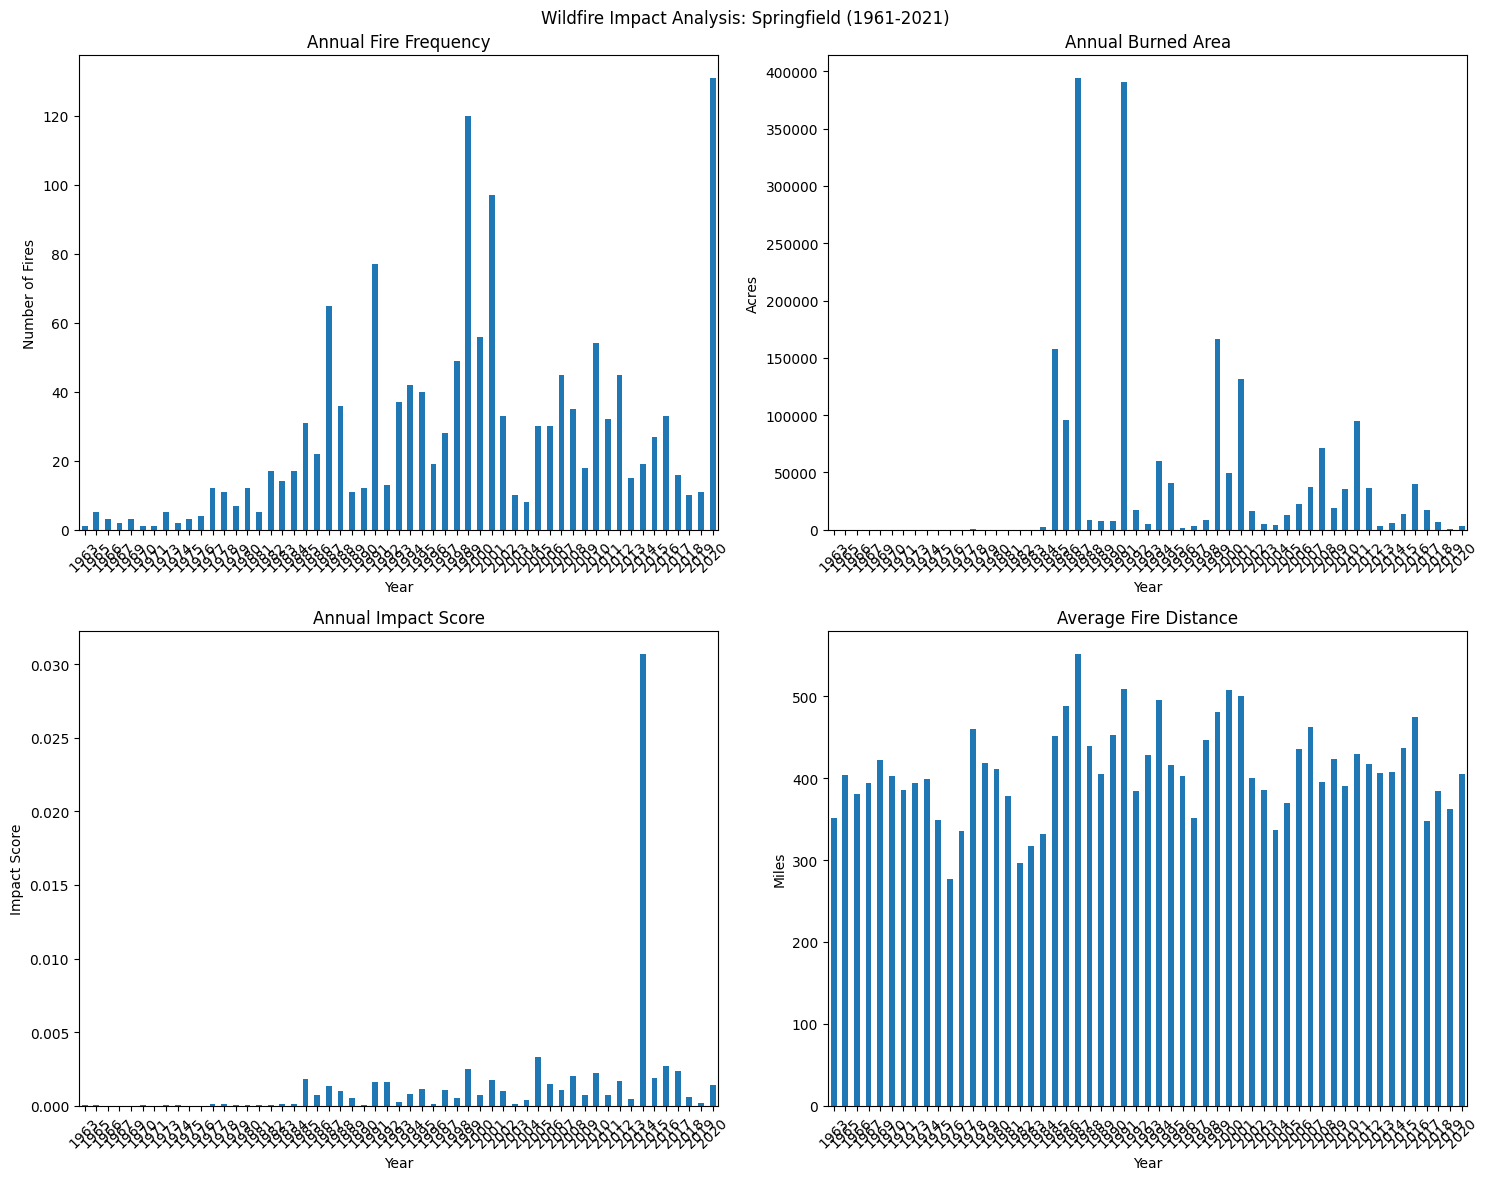

In [7]:
# My city usage
def main():
    # Analysis parameters
    city_info = {
        'name': 'Springfield',
        'location': (42.12, -72.54),  # (lat, lon)
        'year_range': (1961, 2021)
    }
    
    # Setup output directory
    results_dir = 'fire_analysis_results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Load and process data
    data_file = 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
    
    try:
        print(f"Reading data: {data_file}")
        with open(data_file, 'r') as f:
            raw_data = geojson.load(f)
        
        print("Processing records...")
        results = analyze_fire_dataset(
            raw_data['features'],
            city_info['location'],
            city_info['year_range']
        )
        
        if not results.empty:
            # Display results
            print(f"\nWildfire Impact Analysis - {city_info['name']}")
            print(f"Period: {city_info['year_range'][0]}-{city_info['year_range'][1]}")
            print(f"Range: {ANALYSIS_CONFIG['MAX_DISTANCE']} miles")
            print(f"Season: May 1 - October 31\n")
            print(results)
            
            # Save results
            output_file = os.path.join(
                results_dir,
                f'impact_summary_{city_info["name"].lower()}.csv'
            )
            results.to_csv(output_file)
            print(f"\nResults saved: {output_file}")
            
            # Create visualizations
            print("\nGenerating visualizations...")
            create_analysis_plots(
                results,
                city_info['name'],
                city_info['year_range'],
                results_dir
            )
            
        else:
            print("No qualifying data found")
            
    except FileNotFoundError:
        print(f"Data file not found: {data_file}")
    except Exception as e:
        print(f"Analysis failed: {e}")

if __name__ == "__main__":
    main()

# Step 2: Visualize aspects of your analysis

### Task 2 Result: 
### Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

In [14]:
def create_acres_impacted_plot(summary_data, save_path=None):
    """Generate visualization plots of analysis results"""
    try:
        #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # Create a figure and a plot
        fig, ax2 = plt.subplots(figsize=(15, 6))
        
        title = f'Wildfire Impact Analysis: Springfield MA 1961-2021'
        fig.suptitle(title)
        
        # Burned area plot
        summary_data['total_acres'].plot(ax=ax2, kind='bar')
        ax2.set_title('Annual Burned Area')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Acres')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            output_file = Path(save_path) / f'Acres_Impacted_Springfield.png'
            plt.savefig(output_file)
            print(f"Visualizations saved: {output_file}")
            
        plt.show()
        
    except Exception as e:
        print(f"Visualization error: {e}")

data_file = 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
with open(data_file, 'r') as f:
    raw_data = geojson.load(f)


Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0



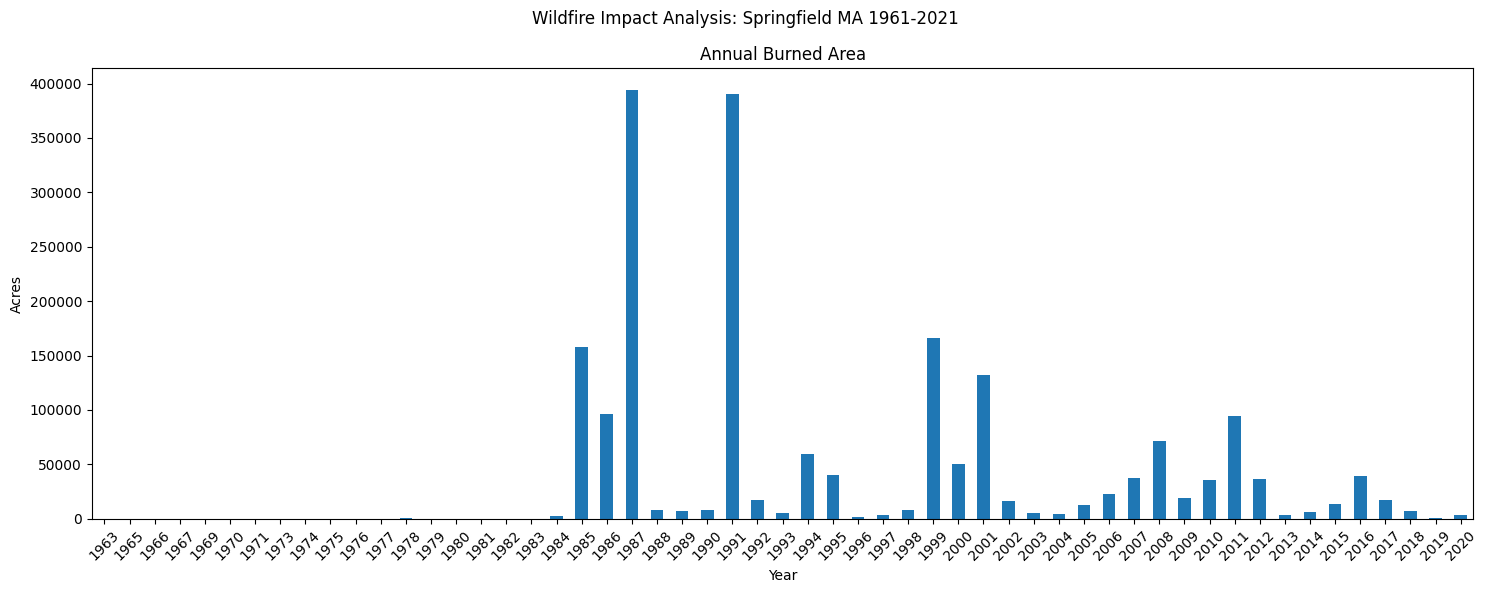

In [15]:
results = analyze_fire_dataset(
            raw_data['features'],
            (42.12, -72.54),
            (1961, 2021)
        )

create_acres_impacted_plot(results) 

### Code for Task 1

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Transformer, Geod
import re
import geojson

# Configuration settings
ANALYSIS_CONFIG_2 = {
    'METERS_TO_MILES': 0.00062137,
    'MAX_DISTANCE': 1800,  # miles
    'FIRE_SEASON': (5, 10),  # May to October
    'DATE_PATTERN': r"Listed Wildfire Discovery Date\(s\): ([^|]+)"
}

# Initialize spatial calculation tools
coord_transformer = Transformer.from_crs("ESRI:102008", "EPSG:4326")
distance_calculator = Geod(ellps='WGS84')

def calculate_distance_to_city(perimeter_coords, city_location):
    """Calculate minimum distance from fire perimeter to city"""
    try:
        if not perimeter_coords:
            return None
            
        city_lon, city_lat = city_location[1], city_location[0]
        distances = []
        
        for coord in perimeter_coords:
            result = distance_calculator.inv(city_lon, city_lat, coord[1], coord[0])
            miles = result[2] * ANALYSIS_CONFIG_2['METERS_TO_MILES']
            distances.append(miles)
            
        return min(distances) if distances else None
        
    except Exception as e:
        print(f"Distance calculation error: {e}")
        return None

# New function to create histogram for distances
def create_distance_histogram(df, city_name):
    """Creates histogram for distances of fires from city in 50-mile intervals up to 1800 miles"""
    plt.figure(figsize=(10, 6))
    bins = range(0, ANALYSIS_CONFIG_2['MAX_DISTANCE'] + 50, 50)
    plt.hist(df['distance_miles'], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Number of Fires by Distance from {city_name}")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Number of Fires")
    
    # Draw distance cut-off line for modeling work
    plt.axvline(ANALYSIS_CONFIG_2['MAX_DISTANCE'], color='red', linestyle='--', label="Modeling Distance Cut-off")
    plt.legend()
    
    # Save plot
    histogram_path = f'distance_histogram_{city_name.lower()}.png'
    plt.savefig(histogram_path)
    print(f"Histogram saved at: {histogram_path}")
    plt.close()

def analyze_fire_dataset(fire_features, city_location, year_range):
    """Process full dataset and generate annual statistics"""
    metrics = {'total': 0, 'analyzed': 0, 'filtered': 0, 'failed': 0}
    processed_records = []
    
    for feature in fire_features:
        metrics['total'] += 1
        result = process_fire_record(feature, city_location, year_range)
        
        if result:
            processed_records.append(result)
            metrics['analyzed'] += 1
        else:
            metrics['filtered'] += 1

    print(f"\nAnalysis Summary:")
    print(f"Total records: {metrics['total']}")
    print(f"Records analyzed: {metrics['analyzed']}")
    print(f"Records filtered: {metrics['filtered']}")
    print(f"Processing errors: {metrics['failed']}\n")
    
    if not processed_records:
        print("No qualifying records found")
        return pd.DataFrame()
        
    df = pd.DataFrame(processed_records)
    
    # Generate histogram for fire distances
    create_distance_histogram(df, 'Springfield')

    return df

# My city usage (main function)

def main(raw_data):
    city_info = {
        'name': 'Springfield',
        'location': (42.12, -72.54),  # (lat, lon)
        'year_range': (1961, 2021)
    }
        
    try:    
        print("Processing records...")
        results = analyze_fire_dataset(
            raw_data['features'],
            city_info['location'],
            city_info['year_range']
        )
        
        if not results.empty:
            print(f"\nWildfire Impact Analysis - {city_info['name']}")
            print(f"Period: {city_info['year_range'][0]}-{city_info['year_range'][1]}")
            print(f"Range: {ANALYSIS_CONFIG_2['MAX_DISTANCE']} miles")
            print(f"Season: May 1 - October 31\n")
            print(results)
            
            output_file = f'impact_summary_1800_{city_info["name"].lower()}.csv'
            results.to_csv(output_file)
            print(f"\nResults saved: {output_file}")
            
        else:
            print("No qualifying data found")
            
    except FileNotFoundError:
        print(f"Data file not found.")
    except Exception as e:
        print(f"Analysis failed: {e}")

if __name__ == "__main__":
    main(raw_data)


Processing records...

Analysis Summary:
Total records: 135061
Records analyzed: 1482
Records filtered: 133579
Processing errors: 0

Histogram saved at: distance_histogram_springfield.png

Wildfire Impact Analysis - Springfield
Period: 1961-2021
Range: 1800 miles
Season: May 1 - October 31

      year                   name   size_acres  distance_miles  smoke_impact  \
0     1963                COLORED    30.743401      351.080962  2.805245e-05   
1     1965             ABRAMS MTN     3.978242      406.399069  9.718302e-06   
2     1965             SANDY BOTT     1.989492      411.251067  6.475019e-06   
3     1965                SKYLAND     1.989099      391.986734  7.126237e-06   
4     1965             LEWIS PEAK     0.248821      421.055094  1.253333e-06   
...    ...                    ...          ...             ...           ...   
1477  2020            Needle Fire     0.000163      173.951036  5.376552e-09   
1478  2020  No Fire Name Provided     0.000015      122.180353  1.02

### Task 1 Result: 
### Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

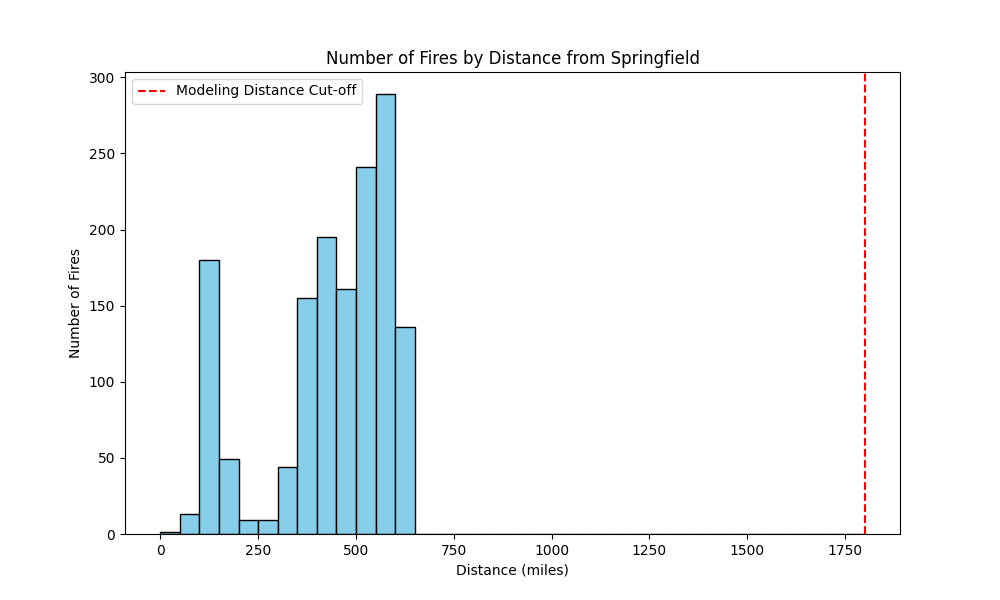

In [32]:
# Display distance_histogram_springfield.png
from IPython.display import Image
Image(filename='distance_histogram_springfield.png')

### Initial Code for Task 3

In [16]:
import pandas as pd
import requests
import json
import time
from datetime import datetime
import numpy as np
import os

# Constants
API_BASE_URL = 'https://aqs.epa.gov/data/api'
SPRINGFIELD_FIPS = '25013'
PM25_PARAM = '88101'

# EPA AQI breakpoints for PM2.5 (μg/m³)
PM25_BREAKPOINTS = {
    'Good': 12.0,
    'Moderate': 35.4,
    'Unhealthy for Sensitive Groups': 55.4,
    'Unhealthy': 150.4,
    'Very Unhealthy': 250.4,
    'Hazardous': 500.4
}

smoke_data = pd.read_csv('fire_analysis_results/impact_summary_springfield.csv')

def fetch_pm25_data(year, email, api_key):
    """Fetch PM2.5 data for a specific year from the EPA API."""
    params = {
        'email': email,
        'key': api_key,
        'param': PM25_PARAM,
        'bdate': f'{year}0101',
        'edate': f'{year}1231',
        'state': SPRINGFIELD_FIPS[:2],
        'county': SPRINGFIELD_FIPS[2:]
    }
    endpoint = '/dailyData/byCounty'
    url = f"{API_BASE_URL}{endpoint}"
    try:
        time.sleep(0.6)  # Rate limiting
        response = requests.get(url, params=params)
        return response.json()
    except Exception as e:
        print(f"Failed to get PM2.5 data for {year}: {e}")
        return None

def calculate_pm25_metrics(aqi_data):
    """Compute annual PM2.5 metrics for smoke detection analysis."""
    if not aqi_data or aqi_data.get("Header", [{}])[0].get("status") != "Success":
        return None
    
    metrics = {
        'days_with_data': 0,
        'mean_pm25': 0.0,
        'median_pm25': 0.0,
        'max_pm25': 0.0,
        'smoke_days': 0,
        'severe_smoke_days': 0,
        'summer_smoke_days': 0,
        'pm25_90th_percentile': 0.0,
        'high_pm25_episodes': 0
    }
    
    daily_values = []
    summer_values = []
    
    for record in aqi_data.get("Data", []):
        if record.get('arithmetic_mean') is not None:
            value = float(record['arithmetic_mean'])
            date = datetime.strptime(record['date_local'], '%Y-%m-%d')
            daily_values.append(value)
            
            # Check summer months (June to September)
            if 6 <= date.month <= 9:
                summer_values.append(value)
            
            # Count smoke and severe smoke days
            if value > PM25_BREAKPOINTS['Moderate']:
                metrics['smoke_days'] += 1
                if 6 <= date.month <= 9:
                    metrics['summer_smoke_days'] += 1
            if value > PM25_BREAKPOINTS['Unhealthy']:
                metrics['severe_smoke_days'] += 1
    
    if daily_values:
        metrics.update({
            'days_with_data': len(daily_values),
            'mean_pm25': np.mean(daily_values),
            'median_pm25': np.median(daily_values),
            'max_pm25': max(daily_values),
            'pm25_90th_percentile': np.percentile(daily_values, 90)
        })
        
        # Calculate episodes of high PM2.5
        consecutive_days = 0
        for value in daily_values:
            if value > PM25_BREAKPOINTS['Moderate']:
                consecutive_days += 1
                if consecutive_days == 2:
                    metrics['high_pm25_episodes'] += 1
            else:
                consecutive_days = 0
    
    return metrics

def validate_smoke_data(email, api_key, start_year=2000, end_year=2020):
    """Validate smoke data against EPA's PM2.5 data."""
    validation_results = []
    
    for year in range(start_year, end_year + 1):
        print(f"Processing year {year}...")
        
        # Get smoke impact score and acres burned for the year
        smoke_score = smoke_data[smoke_data['year'] == year]['smoke_impact_score'].iloc[0]
        acres_burned = smoke_data[smoke_data['year'] == year]['total_acres'].iloc[0]
        
        # Fetch and calculate PM2.5 metrics
        epa_data = fetch_pm25_data(year, email, api_key)
        pm25_metrics = calculate_pm25_metrics(epa_data)
        
        if pm25_metrics:
            result = {
                'year': year,
                'smoke_impact_score': smoke_score,
                'acres_burned': acres_burned,
                **pm25_metrics
            }
            validation_results.append(result)
    
    return pd.DataFrame(validation_results)

def analyze_validation_results(results_df):
    """Analyze validation results for correlation and seasonality insights."""
    # Calculate correlation metrics
    smoke_correlations = {
        'Mean PM2.5': results_df['mean_pm25'].corr(results_df['smoke_impact_score']),
        'Smoke Days': results_df['smoke_days'].corr(results_df['smoke_impact_score']),
        'Summer Smoke Days': results_df['summer_smoke_days'].corr(results_df['smoke_impact_score']),
        'Max PM2.5': results_df['max_pm25'].corr(results_df['smoke_impact_score']),
        '90th Percentile PM2.5': results_df['pm25_90th_percentile'].corr(results_df['smoke_impact_score']),
        'High PM2.5 Episodes': results_df['high_pm25_episodes'].corr(results_df['smoke_impact_score'])
    }
    
    # Determine seasonal smoke pattern
    summer_ratio = results_df['summer_smoke_days'] / results_df['smoke_days']
    
    return {
        'correlations': smoke_correlations,
        'summer_smoke_ratio': summer_ratio.mean(),
        'data_completeness': results_df['days_with_data'].mean() / 365,
        'worst_smoke_years': results_df.nlargest(3, 'smoke_impact_score')[['year', 'smoke_impact_score', 'mean_pm25', 'smoke_days']]
    }





/Users/sparshnagpal/Desktop/UW/Udub Courses/Fall 2024/Data 512 HCDS/Project/Part 1 copy/part1_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
# Replace these with your API credentials
EMAIL = "*******@uw.edu"
API_KEY = "*******"

In [19]:
results_springfield = validate_smoke_data(EMAIL, API_KEY, start_year=1999, end_year=2020)
# 1980 to 1998 Data is not present due to lack in sensors for the county during the time period
results_springfield.to_csv('Springfield_AQI.csv', index=False)  # Save results if needed

Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...


### Analysis

In [20]:
# Alternatively, read from saved file
results_springfield = pd.read_csv('Springfield_AQI.csv')
analysis_town = analyze_validation_results(results_springfield)
analysis_town

{'correlations': {'Mean PM2.5': np.float64(-0.27277953654034975),
  'Smoke Days': np.float64(-0.1670568432090904),
  'Summer Smoke Days': np.float64(-0.13209458544317243),
  'Max PM2.5': np.float64(-0.22653042646744717),
  '90th Percentile PM2.5': np.float64(-0.25406094908435006),
  'High PM2.5 Episodes': np.float64(-0.1716365463904164)},
 'summer_smoke_ratio': np.float64(0.5310719026564243),
 'data_completeness': np.float64(12.877210460772105),
 'worst_smoke_years':     year  smoke_impact_score  mean_pm25  smoke_days
 15  2014            0.030692   5.989691           0
 6   2005            0.003295  12.107126          40
 17  2016            0.002681   6.005374           0}

In [21]:
print("\nValidation Results:")
print(results_springfield.to_string())
print("\nAnalysis:")
print(json.dumps(analysis_town, indent=2, default=str))


Validation Results:
    year  smoke_impact_score   acres_burned  days_with_data  mean_pm25  median_pm25   max_pm25  smoke_days  severe_smoke_days  summer_smoke_days  pm25_90th_percentile  high_pm25_episodes
0   1999            0.002512  166457.264311            4072  12.726916    10.400000  47.700000         120                  0                 64                 23.17                  17
1   2000            0.000752   49903.751975            5000  13.046720    10.900000  52.400000          96                  0                  0                 23.20                  12
2   2001            0.001747  131694.132196            5064  12.700158    10.600000  63.800000          88                  0                 16                 24.00                  11
3   2002            0.000975   16535.509288            5868  13.198875    10.200000  78.400000         206                  0                158                 24.00                  16
4   2003            0.000118    5167.362844 

In [23]:
%%capture
%pip install seaborn

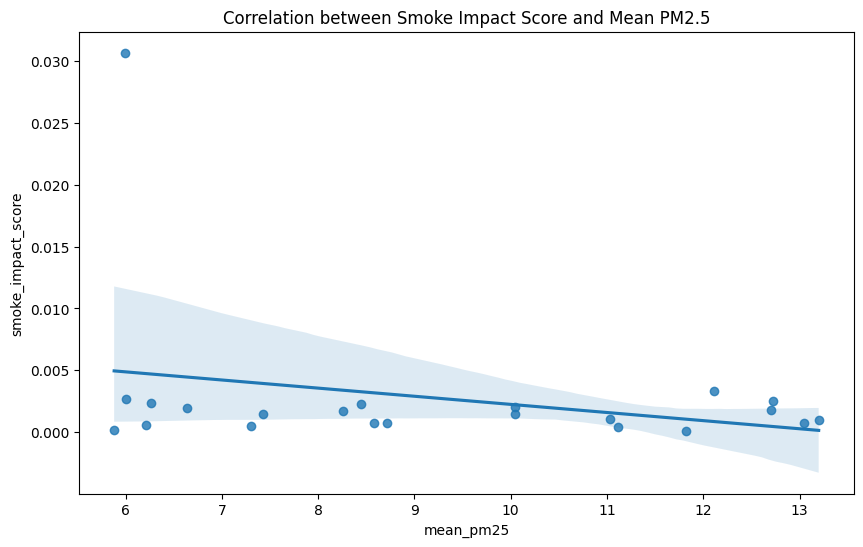

In [24]:
results_springfield['smoke_impact_score'].corr(results_springfield['mean_pm25'])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x='mean_pm25', y='smoke_impact_score', data=results_springfield)
plt.title('Correlation between Smoke Impact Score and Mean PM2.5')

plt.show()

In [25]:
# Print correlation between smoke impact score and PM2.5 

results_springfield['smoke_impact_score'].corr(results_springfield['mean_pm25'])


np.float64(-0.27277953654034975)

### Forecasting Result

  Using cached scikit_learn-1.5.2-cp39-cp39-macosx_12_0_arm64.whl (11.0 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
You should consider upgrading via the '/Users/sparshnagpal/Desktop/UW/Udub Courses/Fall 2024/Data 512 HCDS/Project/Part 1 copy/part1_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


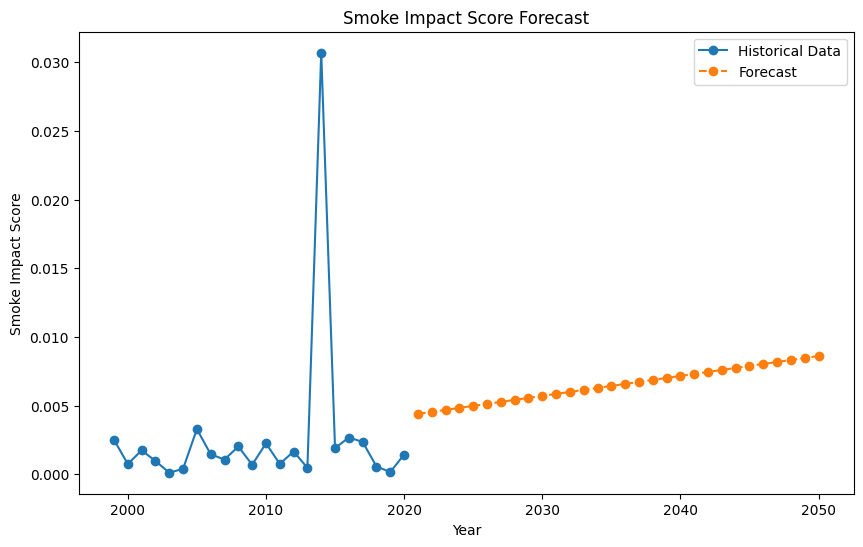

In [26]:
# Forecasting
%pip install scikit-learn
from sklearn.linear_model import LinearRegression

X = results_springfield[['year']]

# Scale the target variable
y = results_springfield['smoke_impact_score'] * 100

# Fit a linear regression model
model = LinearRegression()

model.fit(X, y)

# Forecast for years 2021-2050
future_years = pd.DataFrame({'year': range(2021, 2051)})

future_scores = model.predict(future_years)

# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(results_springfield['year'], results_springfield['smoke_impact_score'], 'o-', label='Historical Data')

plt.plot(future_years['year'], future_scores / 100, 'o--', label='Forecast')

plt.xlabel('Year')

plt.ylabel('Smoke Impact Score')

plt.title('Smoke Impact Score Forecast')

plt.legend()

plt.show()



### Task 3 Result: 
### Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

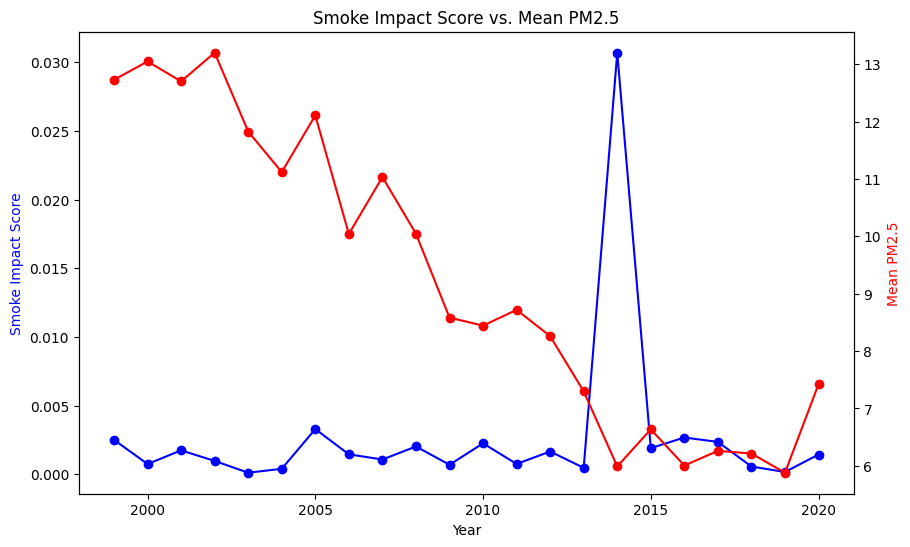

In [27]:
# Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city. Make a scatterplot
# Have two different y-axis, one for the smoke impact score and one for the AQI

plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(results_springfield['year'], results_springfield['smoke_impact_score'], 'o-', color='b', label='Smoke Impact Score')
ax2.plot(results_springfield['year'], results_springfield['mean_pm25'], 'o-', color='r', label='Mean PM2.5')

ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Impact Score', color='b')
ax2.set_ylabel('Mean PM2.5', color='r')

plt.title('Smoke Impact Score vs. Mean PM2.5')

plt.show()


